In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_score, recall_score, roc_auc_score, accuracy_score, auc
from sklearn.calibration import CalibrationDisplay
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

%load_ext watermark
%watermark -n -u -v -iv -w -p sklearn

Last updated: Mon Mar 25 2024

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.12.0

sklearn: 1.4.0

arviz     : 0.17.0
numpy     : 1.26.3
matplotlib: 3.8.2
seaborn   : 0.13.2
pymc      : 5.10.3
pandas    : 2.2.0

Watermark: 2.4.3



In [2]:
import os

os.chdir("D:/Programming/project1/Transmission_probability/method3_enveloppes/v_PyMC/")

In [5]:
df = pd.read_excel("Input/v_minutes/under_15m/enveloppe8_0.2_pivot.xlsx")
df1 = pd.read_excel("Input/v_minutes/under_15m/enveloppe8_0.2.xlsx")
y = df1["infected"].to_numpy()

In [6]:
# Pre-calculate unique combinations of experiment and contact_duration
unique_combinations = df[['experiment', 'contact_duration']].drop_duplicates()

# Convert to a list of tuples for iteration
unique_combinations = [tuple(x) for x in unique_combinations.to_numpy()]

In [7]:
%%time
model = pm.Model()
with pm.Model() as model:
    # Priors
    p0 = pm.Beta('p0', alpha=1, beta=1)
    lambda_ = pm.LogNormal('lambda', mu = -1, sigma=0.1)

    # Loop through data
    for e, c in unique_combinations:
        df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c)]
        ids = df_temp['cap_ID'].unique()
            
        # Iterate over unique cap_IDs
        for _, group in df_temp.groupby('cap_ID'):
            distances = group['distance'].values
            times = group['time'].values
            p_temp = (1 - (p0 * pm.math.exp(-lambda_ * distances))) ** times   
            p_i = pm.math.prod(p_temp)
            p = 1 - p_i
                
    # Likelihood
    y_true = pm.Bernoulli('y_obs', p = p, observed=y)

    inits = {'p0': 0.001, 'lambda': 0.1}

CPU times: total: 250 ms
Wall time: 295 ms


In [8]:
%%time
with model:
    trace = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=inits, random_seed=42)

Compiling...
Compilation time = 0:00:03.966672
Sampling...
Sampling time = 0:00:05.581227
Transforming variables...
Transformation time = 0:00:00.118599


CPU times: total: 10.6 s
Wall time: 10 s


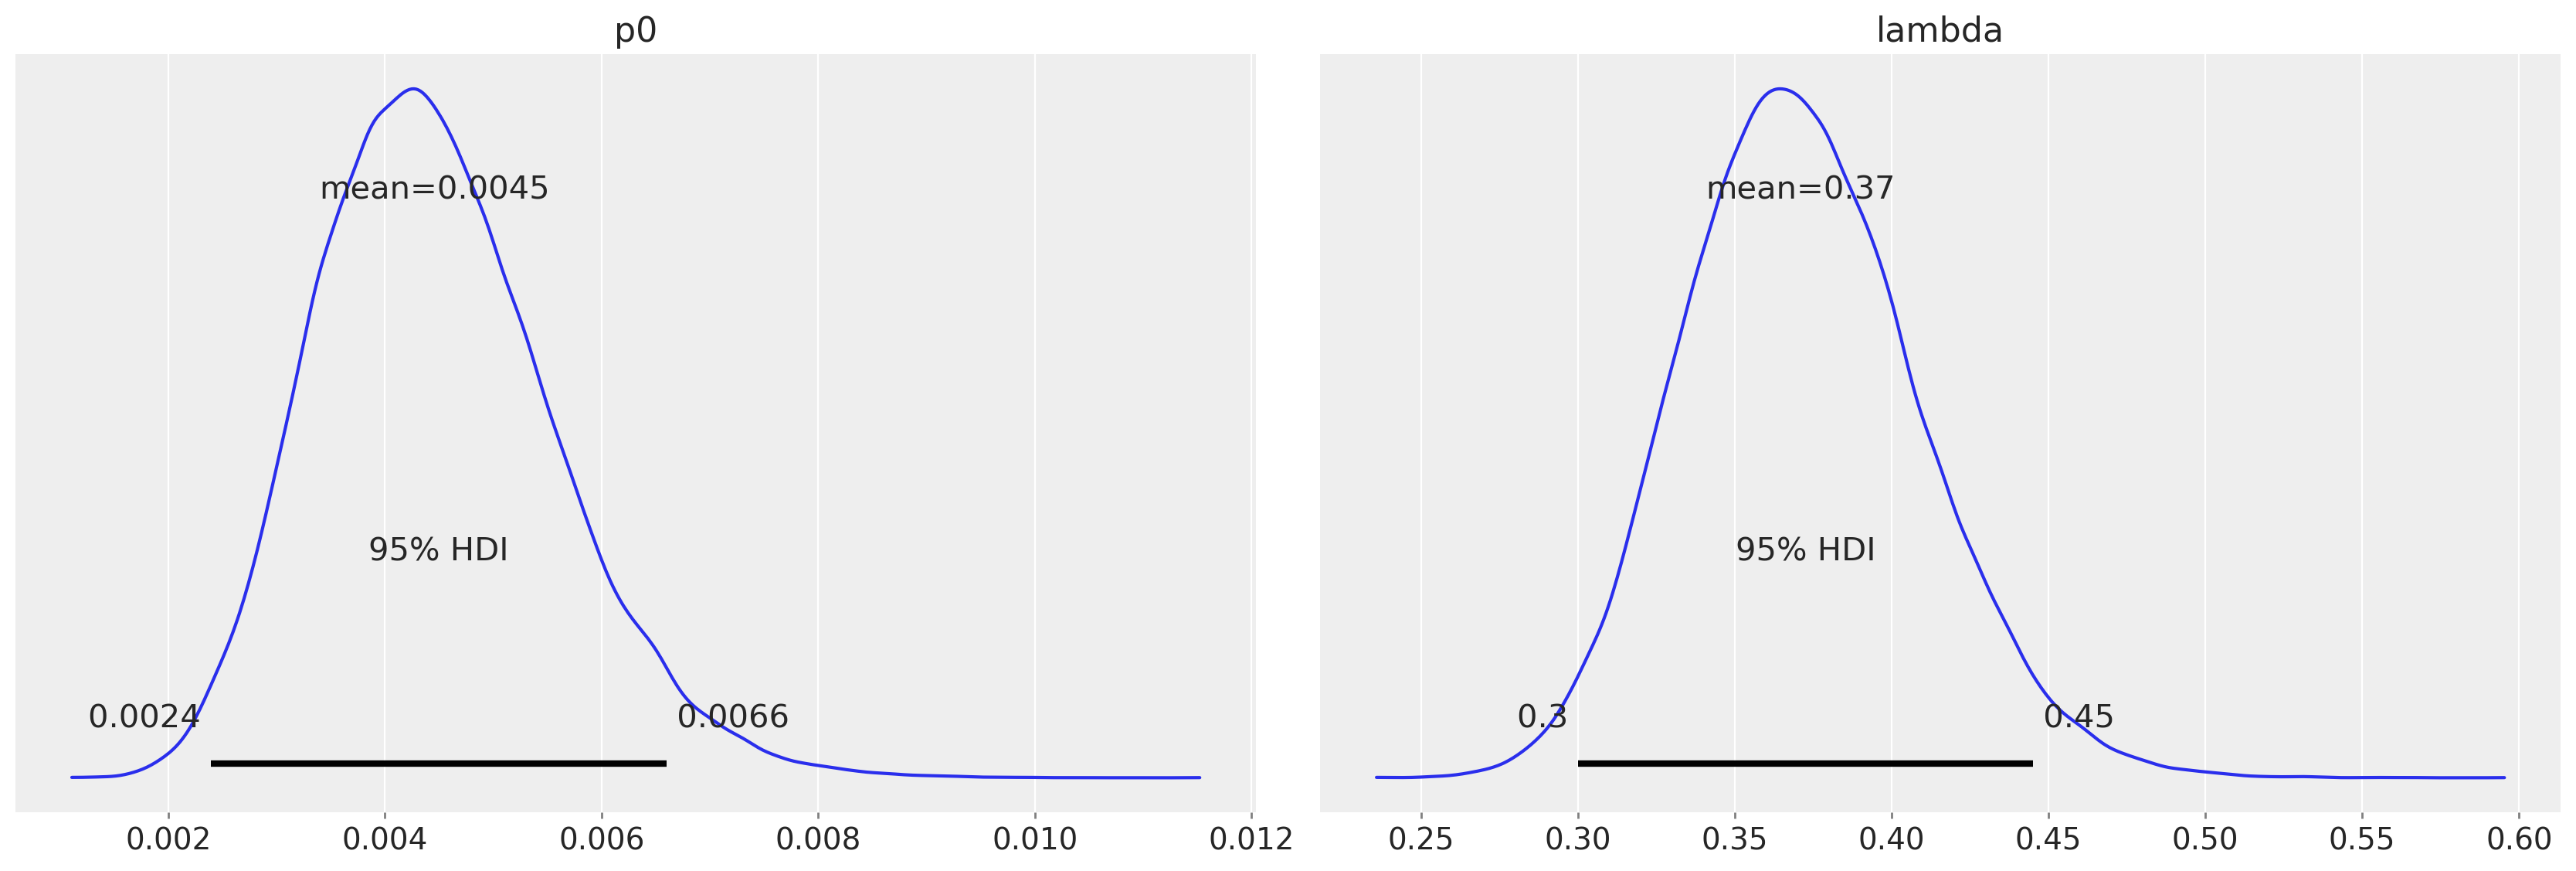

In [9]:
az.plot_posterior(trace, var_names=["p0", "lambda"], hdi_prob=.95);

In [10]:
az.summary(trace, round_to=4, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p0,0.0045,0.0011,0.0024,0.0066,0.0000,0.0000,64941.1711,54127.8077,1.0001
lambda,0.3711,0.0374,0.3002,0.4452,0.0001,0.0001,63192.9882,59348.9744,1.0001


In [9]:
with open('Output2/trace_enveloppe_1.5m_0.1.pkl', 'wb') as f:
    pickle.dump(trace, f)

In [9]:
p0_sample = trace.posterior["p0"].stack(sample=("chain", "draw")).values
p0_sample = np.random.choice(p0_sample, size=1000)
lambda_sample = trace.posterior["lambda"].stack(sample=("chain", "draw")).values
lambda_sample = np.random.choice(lambda_sample, size=1000)

In [10]:
# Initialize the list for predictions
pred = []

# Iterate over samples
for j in range(len(lambda_sample)):
    a = lambda_sample[j]
    b = p0_sample[j]
    pred_parametre = []
    
    # Iterate over unique combinations of experiment and contact_duration
    for e, c in unique_combinations:
        df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c)]
        ids = df_temp['cap_ID'].unique()
        
        # Iterate over unique cap_IDs
        for id in ids:
            p_i = 1
            datai = df_temp[df_temp['cap_ID'] == id]
            distances = datai['distance'].values
            times = datai['time'].values
            
            # Vectorized calculation of p_temp
            p_temp = (1 - (b * np.exp(a * distances))) ** times
            
            # Product of probabilities for the cap_ID
            p_i = np.prod(p_temp)
            
            # Append the final calculation for the cap_ID
            pred_parametre.append(1 - p_i)
    
    # Append predictions for this sample
    pred.append(pred_parametre)

In [11]:
simulations_proba = pd.DataFrame({f'y_pred{i+1}': sublist for i, sublist in enumerate(pred)})

simulations_bernoulli = simulations_proba.map(lambda prob: np.random.binomial(1, prob))

In [12]:
proportions = simulations_bernoulli.mean(axis=1)
df_proportions = pd.DataFrame(proportions, columns=['y_pred'])
df_proportions.insert(0, 'y_true', y)
simulations_proba.insert(0, 'y_true', y)

In [13]:
y_true = df_proportions['y_true']
y_pred = df_proportions['y_pred']

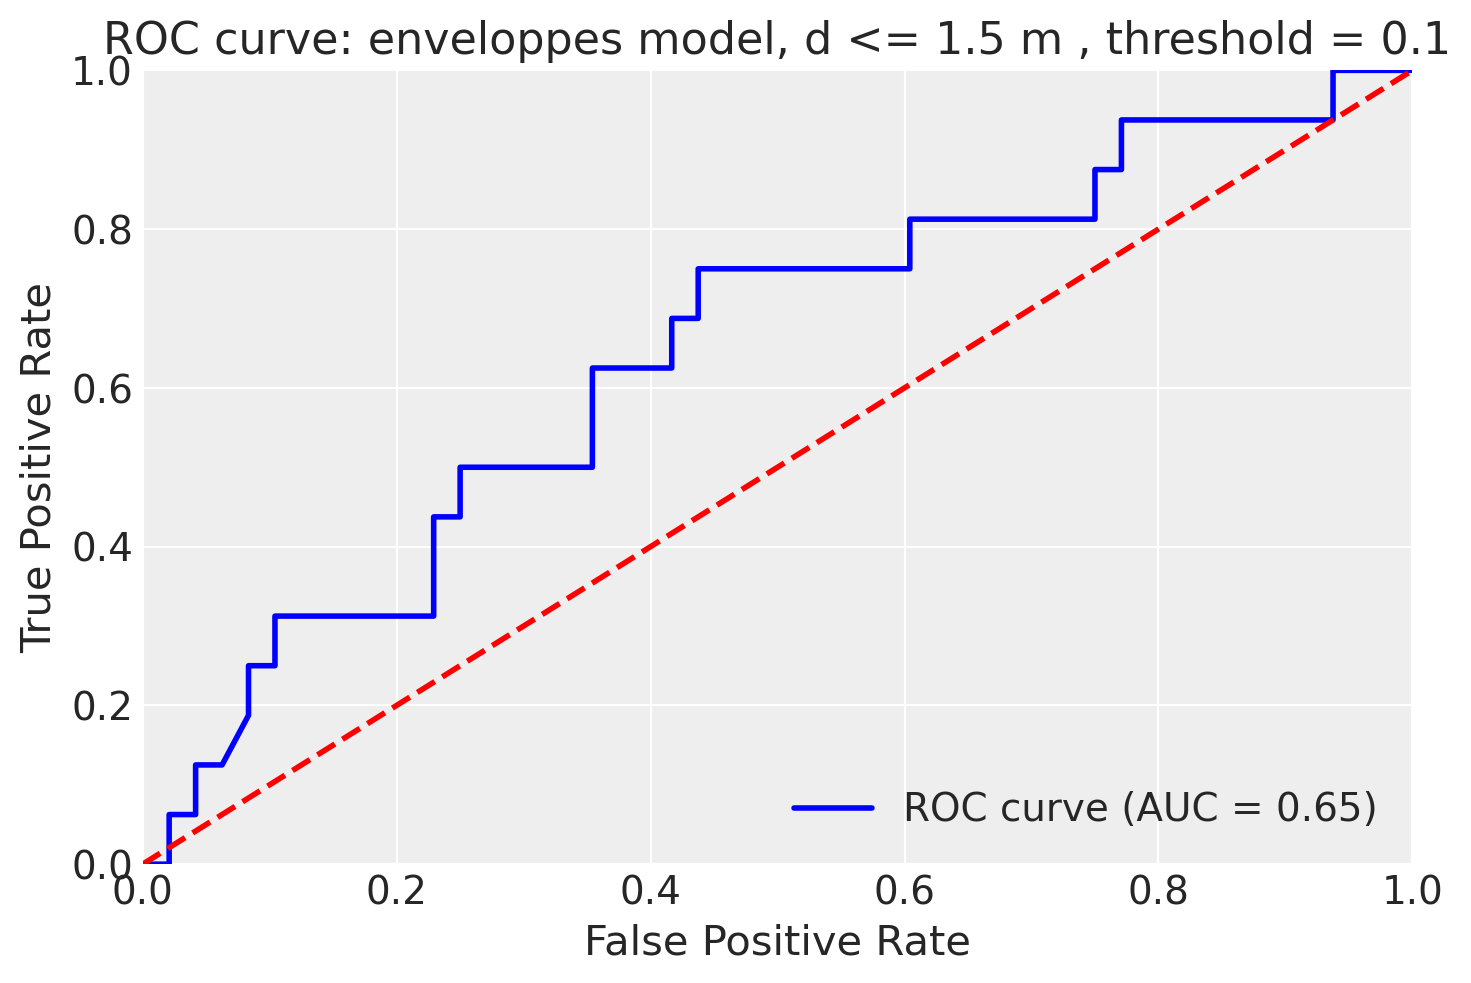

In [14]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: enveloppes model, d <= 1.5 m , threshold = 0.1')
plt.legend(loc="lower right")
plt.show()

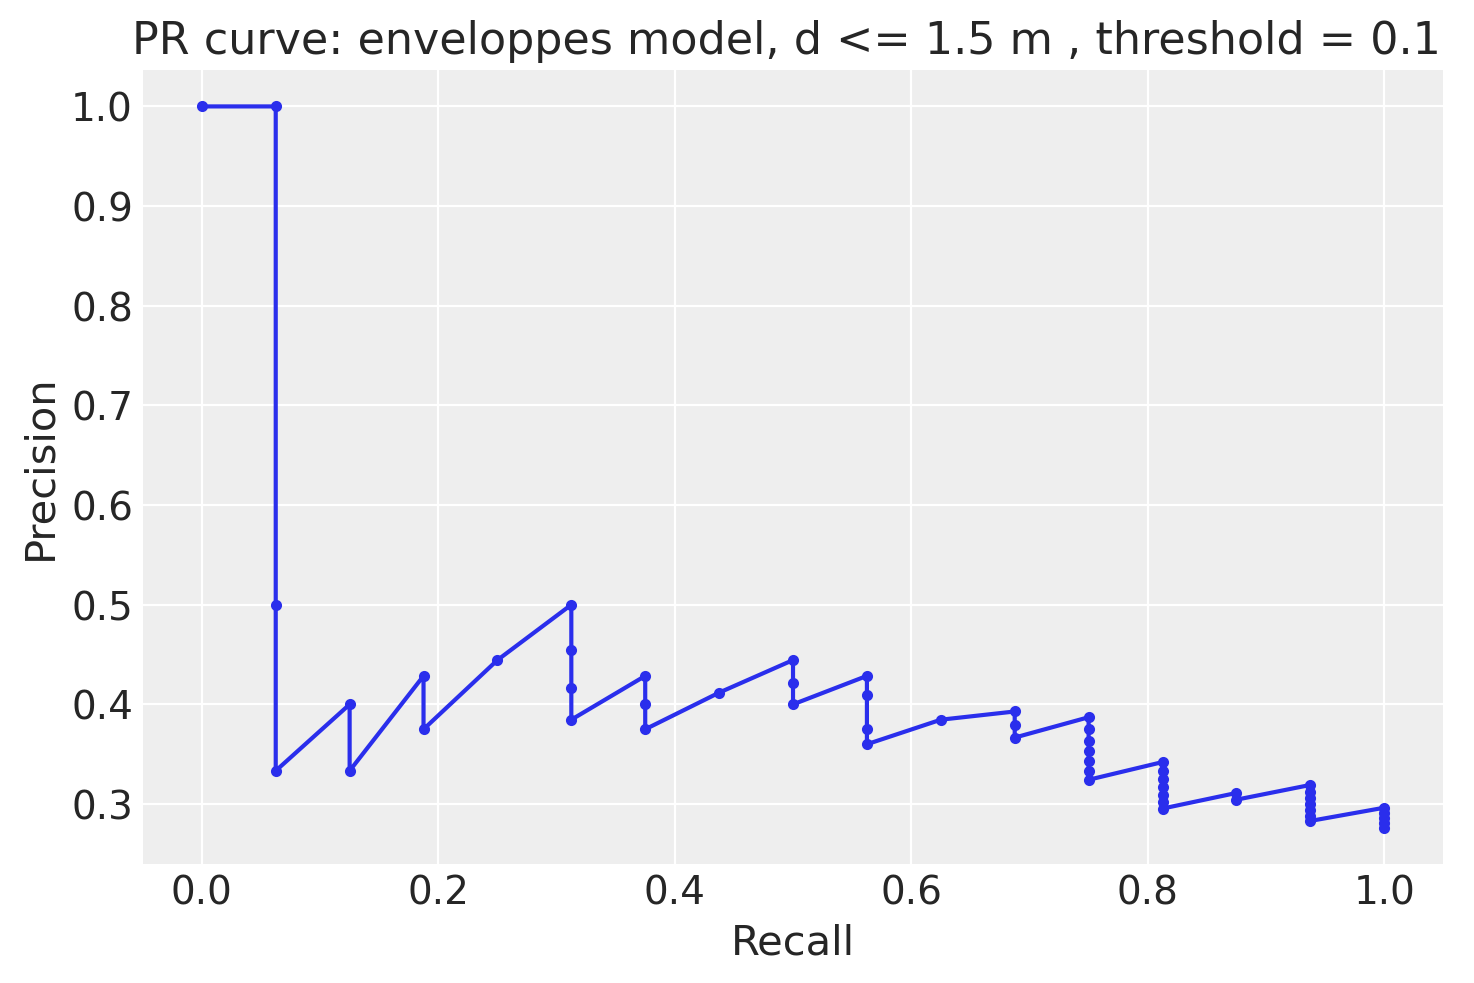

In [16]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR curve: enveloppes model, d <= 1.5 m , threshold = 0.1 ')
plt.show()

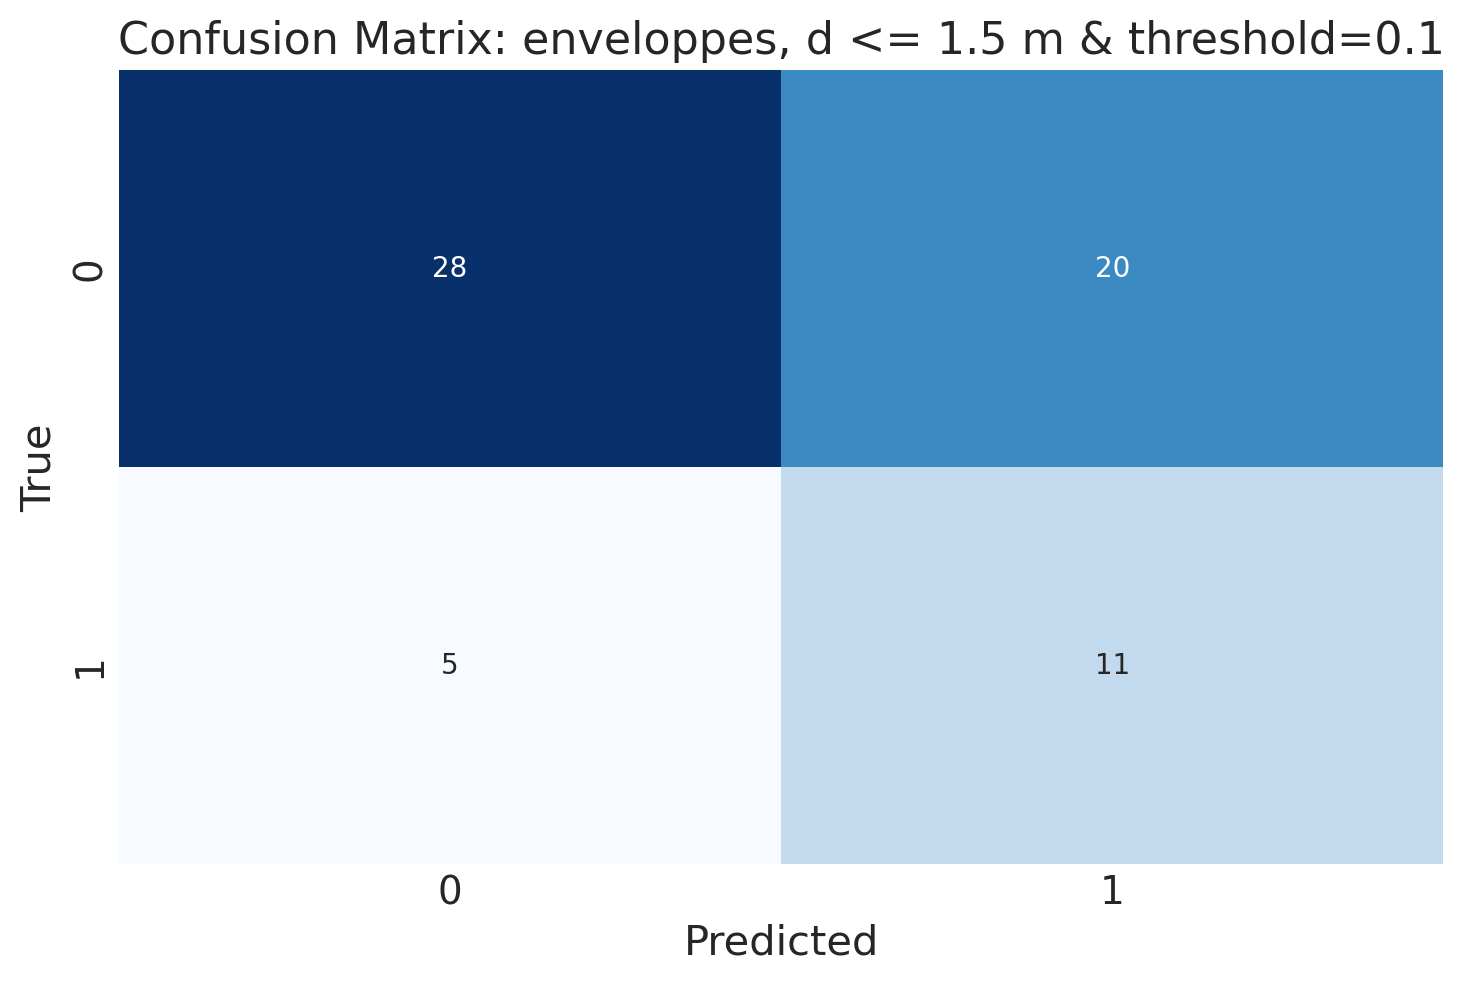

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert probabilities to binary predictions
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# Now you can compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: enveloppes, d <= 1.5 m & threshold=0.1')
plt.show()

In [20]:
df1['animal_ID'] = df1['experiment'].astype(str) + '_' + df1['contact_duration'].astype(str) + '_' + df1['cap_ID'].astype(str)

In [21]:
df_proportions.insert(0, 'animal_ID', df1['animal_ID'])

In [22]:
df_proportions.sort_values(by=['y_true', 'animal_ID'], ascending= True, inplace=True)
df_proportions.to_excel('Output2/df_proportions_1.5m_0.1.xlsx', index=False)

In [23]:
df_proportions = pd.read_excel("Output2/df_proportions_1.5m_0.1.xlsx")

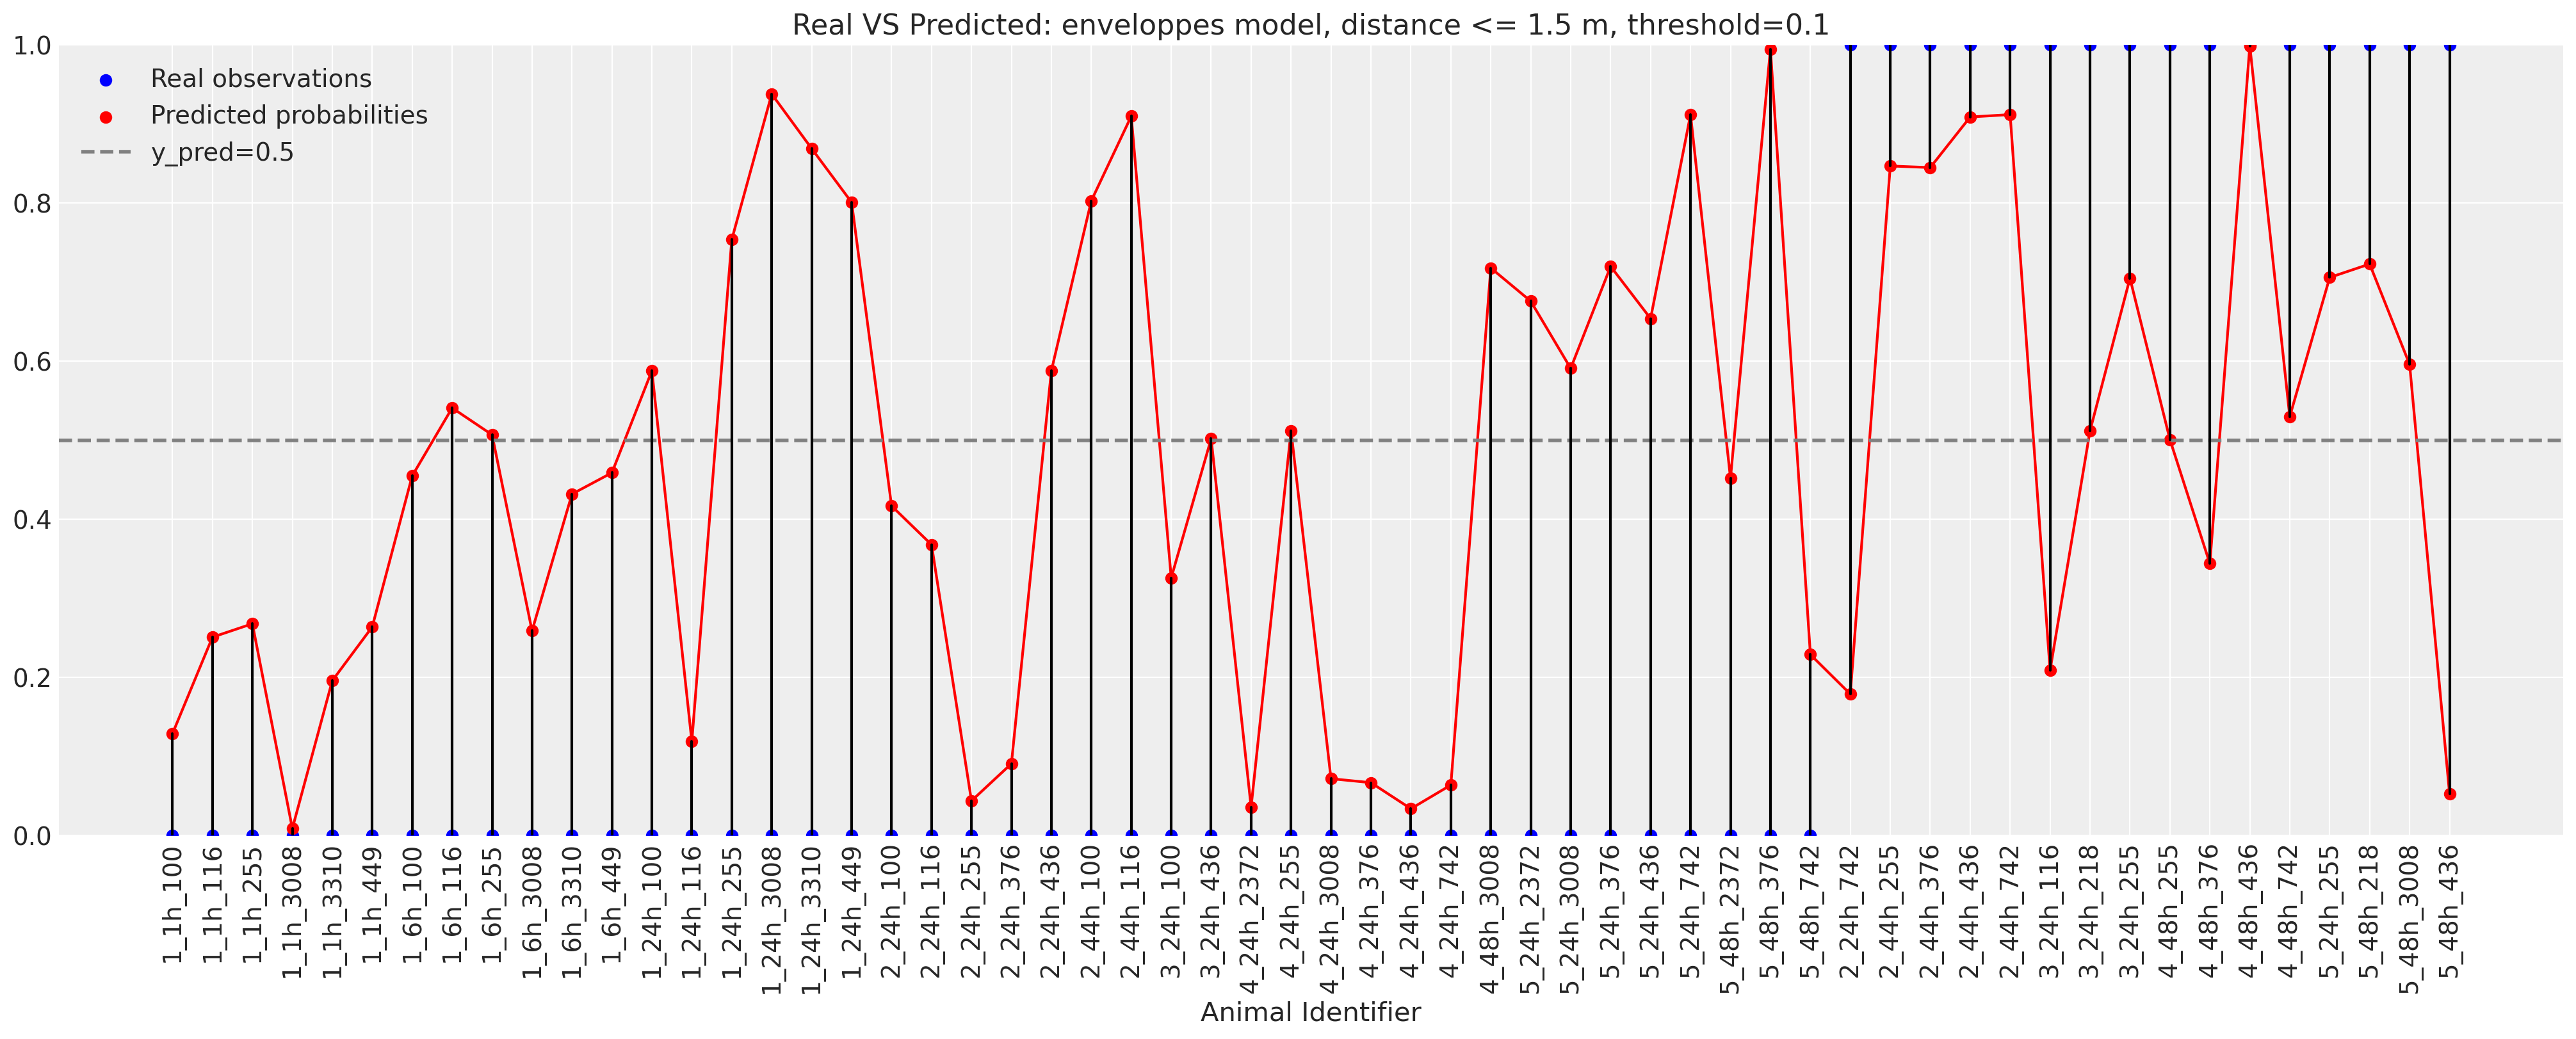

In [24]:
# Créer une figure et un axe
fig, ax = plt.subplots(figsize = (20, 8))

# Tracer les points pour y_true et y_pred
ax.scatter(df_proportions['animal_ID'], df_proportions['y_true'], color='blue', label='Real observations')
ax.scatter(df_proportions['animal_ID'],df_proportions['y_pred'], color='red', label='Predicted probabilities')
ax.plot(df_proportions['animal_ID'], df_proportions['y_pred'], color='red')
ax.axhline(0.5, color='gray', lw=2, linestyle='--', label= 'y_pred=0.5')

# Tracer les boîtes entre y_true et y_pred
for i in range(len(df_proportions)):
    ax.plot([df_proportions['animal_ID'].iloc[i]]*2, [df_proportions['y_true'].iloc[i], df_proportions['y_pred'].iloc[i]], color='black')

# Définir les limites de l'axe des y
ax.set_ylim([0, 1])

for label in ax.get_xticklabels():
    label.set_rotation(90)

# Ajouter une légende
ax.legend()
plt.title("Real VS Predicted: enveloppes model, distance <= 1.5 m, threshold=0.1")
plt.xlabel("Animal Identifier")

plt.show()

In [ ]:
y_true = simulations['y_true']

In [ ]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.4f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: enveloppes 1.5m , seuil = 0.1')
    plt.legend(loc="lower right")

In [ ]:
aucs = []

# Boucle sur chaque colonne d'estimations
for col in simulations.columns[1:] : # Commencer à partir de la deuxième colonne car la première est y_true
    y_pred = simulations[col]
    auc = roc_auc_score(y_true, y_pred)
    aucs.append(auc)


In [ ]:
# Trouver l'indice du maximum dans la liste d'AUC
indice_max_auc = np.argmax(aucs)

# Récupérer la colonne d'estimation avec le maximum d'AUC
col_max_auc = simulations.columns[indice_max_auc + 1]  # +1 pour compenser la première colonne (y_true)

# Afficher la colonne d'estimation avec le maximum d'AUC
print(f"La colonne avec le maximum d'AUC est : {col_max_auc}")

In [ ]:
mean_auc = np.mean(aucs)
median_auc = np.median(aucs)

print("mean auc:", mean_auc)
print("median auc:", median_auc)

q1 = np.quantile(aucs, 0.25)
q3 = np.quantile(aucs, 0.75)

if q3 == q1: 
   print("Not enough data")
else:
   iqr = q3 - q1  
   lower = q1 - 1.5 * iqr
   upper = q3 + 1.5 * iqr 
   conf_interval = (lower, upper)

   print(conf_interval)

In [ ]:
y_pred = simulations['y_pred12']

In [ ]:
plot_roc_curve(y_true, y_pred)

In [ ]:
# Plot histogram  
plt.hist(y_true, bins=30, density=True)
plt.hist(y_pred, bins=30, density=True)
plt.vlines(y_pred.mean(), 0, 0.4, colors='r') 

plt.xlabel('Sampled θ')  
plt.ylabel('Density')
plt.title('Posterior Distribution')
   
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred > 0.5) 
print(accuracy)

In [ ]:
from sklearn.metrics import precision_score, recall_score  

precision = precision_score(y_true, y_pred > 0.5)  
recall = recall_score(y_true, y_pred > 0.5)

print(precision, recall)

In [ ]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_true, y_pred)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

specificity = 1 - fpr
plt.plot(specificity, tpr, color='green', label='Sensitivity')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity/Specificity Curve')
plt.legend(loc="lower right")
plt.show()

# Posterior analysis

In [ ]:
az.plot_trace(trace, combined=True);

In [ ]:
az.summary(trace, round_to=6)

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
az.plot_energy(trace);

# Model log-likelihood

In [ ]:
with model:
    pm.compute_log_likelihood(trace)

In [ ]:
model_loo = az.loo(trace)

model_loo

In [ ]:
model_waic = az.waic(trace)

model_waic

In [ ]:
# Generate posterior predictive samples
with model:
    pm.sample_posterior_predictive(trace, random_seed=42, extend_inferencedata=True)

In [ ]:
trace.posterior_predictive

In [ ]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'kde', group="posterior");

In [ ]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'cumulative');

In [ ]:
az.plot_ppc(trace, num_pp_samples=5, kind = 'scatter');

In [ ]:
az.plot_autocorr(trace, var_names=["p0", "lambda"]);

In [ ]:
# Gelman-Rubin convergence diagnostic
r_hat = az.rhat(trace, var_names=["p0", "lambda"])
print(r_hat)

In [ ]:
ess = az.ess(trace, var_names=["p0", "lambda"])

In [ ]:
az.plot_ess(trace, var_names=["p0", "lambda"], kind="evolution");

In [ ]:
total_ess = ess["p0"].sum().values
print(f"Total effective sample size for p0: {float(total_ess):.2f}")

In [ ]:
total_ess = ess["lambda"].sum().values
print(f"Total effective sample size for lambda: {float(total_ess):.2f}")